In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.io import read_image

import pickle
import pandas as pd
import math
import json
import numpy as np
import cv2
from my_classes import Dataset, Net_separate, Net_combined
from utills import rotationMatrixToEulerAngles, generate_label


import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter


In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
CUDA_LAUNCH_BLOCKING=1,

# Parameters

In [3]:
n_bins = 8
params = {'batch_size' : 10,
         'shuffle' : True,
         'num_workers' : 1}
max_epochs = 25

# Choose train, and validation set

Set 1/10 data as a validation set.

    train_val : contains category agnostic traning set and val set.
    train_val_per_category : contains per category traning set and val set.

In [4]:
# #separate train and val
# #separate categories

# #all info about imgs
# csv_file = open("../../Datasets/pix3d/Pix3D/Pix3D.txt")
# data_f = pd.read_csv(csv_file)

# #all infor about all imgs in all categories
# dict_pix3d = np.asarray(data_f)

# #categories of objects (bed, chair,and ...)
# cats = np.unique(data_f.cat_id)

# # dict for all info about all images seprated by categories. exm: {bed:[[im1_info],...],...}
# dict_object_based = dict()#separate train and val
# #separate categories

# #all info about imgs
# csv_file = open("../../Datasets/pix3d/Pix3D/Pix3D.txt")
# data_f = pd.read_csv(csv_file)

# #all infor about all imgs in all categories
# dict_pix3d = np.asarray(data_f)

# #categories of objects (bed, chair,and ...)
# cats = np.unique(data_f.cat_id)

# # dict for all info about all images seprated by categories. exm: {bed:[[im1_info],...],...}
# dict_object_based = dict()

# #dict for train set and val set separatly for each category
# train_val_per_category = dict()

# #dict for category agnostic train val 
# train_val = dict()

# #choosing train_val set
# for i in cats:
#     dict_object_based[i] = dict_pix3d[dict_pix3d[:, 6] == i] #get all the info for all imgs in category i
#     partition = len(dict_object_based[i])
#     train_val_per_category[i] = dict()
#     train_val_per_category[i]["train_set"], train_val_per_category[i]["val_set"] = torch.utils.data.random_split(dict_object_based[i],[partition - int(partition/10), int(partition/10)] )
#     print(i, [partition - int(partition/10), int(partition/10)] )
#     if (len(train_val) == 0):
#         train_val["train_set"] = train_val_per_category[i]["train_set"]
#         train_val["val_set"] = train_val_per_category[i]["val_set"]
    
#     else:
#         train_val["train_set"] = torch.utils.data.ConcatDataset([train_val["train_set"], train_val_per_category[i]["train_set"]])
#         train_val["val_set"] = torch.utils.data.ConcatDataset([train_val["val_set"], train_val_per_category[i]["val_set"]])

# print("All", [len(train_val["train_set"]), len(train_val["val_set"])] )

# with open('filename.pickle', 'wb') as handle:
#     pickle.dump(train_val, handle, protocol=pickle.HIGHEST_PROTOCOL)

# #dict for train set and val set separatly for each category
# train_val_per_category = dict()

# #dict for category agnostic train val 
# train_val = dict()

# #choosing train_val set
# for i in cats:
#     dict_object_based[i] = dict_pix3d[dict_pix3d[:, 6] == i] #get all the info for all imgs in category i
#     partition = len(dict_object_based[i])
#     train_val_per_category[i] = dict()
#     train_val_per_category[i]["train_set"], train_val_per_category[i]["val_set"] = torch.utils.data.random_split(dict_object_based[i],[partition - int(partition/10), int(partition/10)] )
#     print(i, [partition - int(partition/10), int(partition/10)] )
#     if (len(train_val) == 0):
#         train_val["train_set"] = train_val_per_category[i]["train_set"]
#         train_val["val_set"] = train_val_per_category[i]["val_set"]
    
#     else:
#         train_val["train_set"] = torch.utils.data.ConcatDataset([train_val["train_set"], train_val_per_category[i]["train_set"]])
#         train_val["val_set"] = torch.utils.data.ConcatDataset([train_val["val_set"], train_val_per_category[i]["val_set"]])

# print("All", [len(train_val["train_set"]), len(train_val["val_set"])] )

# with open('filename.pickle', 'wb') as handle:
#     pickle.dump(train_val, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Distribution of train-val

Visualizing the histogram of the train and val set based on the number of bins.

All azimuth, elevation, and inplace rotation are visualized


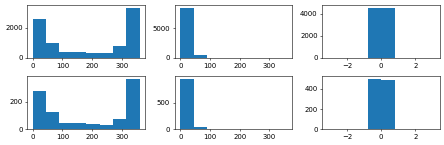

In [5]:
with open('train_test_sp.pickle', 'rb') as handle:
    b = pickle.load(handle)

train_val = b        
#labels = np.asarray(train_val_per_category["chair"]["train_set"])[:,-3:]
train_labels = np.asarray(train_val["train_set"])[:,-3:]
val_labels = np.asarray(train_val["val_set"])[:,-3:]

x_train, y_train, z_train = train_labels[:,0], train_labels[:,1], train_labels[:,2]
x_val, y_val, z_val= val_labels[:,0], val_labels[:,1], val_labels[:,2]

# We can set the number of bins with the `bins` 

yaws_hist_train, binX = np.histogram(x_train, bins=n_bins, range=(0,360))
pich_hist_train, binY = np.histogram(y_train, bins=n_bins, range=(0,360))
roll_hist_train, binZ = np.histogram(z_train, bins=n_bins, range=(-math.pi,math.pi))

yaws_hist_val, binX_val = np.histogram(x_val, bins=n_bins, range=(0,360))
pich_hist_val, binY_val = np.histogram(y_val, bins=n_bins, range=(0,360))
roll_hist_val, binZ_val = np.histogram(z_val, bins=n_bins, range=(-math.pi,math.pi))

fig, axs = plt.subplots(2, 3 ,tight_layout=True,figsize=(9,3),dpi=50)

# histogram of the train set
axs[0,0].hist(x_train,binX )
axs[0,1].hist(y_train,binY )
axs[0,2].hist(z_train,binZ ) 

# histogram of the validation set 
axs[1,0].hist(x_val,binX_val )
axs[1,1].hist(y_val,binY_val )
axs[1,2].hist(z_val,binZ_val )
plt.show()


# Category agnostic dataset prepration 

Using Dataset calss in classes file, and torch.utils.data.DataLoader.

In [6]:
training_set = Dataset(np.asarray(train_val["train_set"]),generate_label(train_val, n_bins, "train_set","chair", 0 ))
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = Dataset(np.asarray(train_val["val_set"]),generate_label(train_val, n_bins, "val_set", "chair", 0 ))
validation_generator = torch.utils.data.DataLoader(validation_set, **params)


# Category level dataset prepration 

Using Dataset calss in classes file, and torch.utils.data.DataLoader.

Please uncomment the following cell if you want to train category level. Also choose the category. 


In [7]:
# training_set = Dataset(np.asarray(train_val["train_set"]),generate_label(train_val, n_bins, "train_set","chair", 1 ))
# training_generator = torch.utils.data.DataLoader(training_set, **params)

# validation_set = Dataset(np.asarray(train_val["val_set"]),generate_label(train_val, n_bins, "val_set", "chair", 1 ))
# validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Model and Loss

The details of the model is in file my_classes.
In general we have 2 main model. 
    
    1) Net_combined() : The normal, boundries mask and rgb are all feed to a single convolution as 8 chanels. 
    2) Net_separate() :Each normal, boundries, mask, and rgb feed to a diffrent convolution layers. The features are combind to gether to estimate the pose.

The loss function is cross entropy loss. I used Adam optimizer.

In [8]:
#models

#model = Net_separate()
model = Net_combined(1,1,1,1)
model.to(device)

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001,)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [9]:
# only rgb 
model_rgb = Net_combined(1,0,0,0)
model_rgb.to(device)

model_rgb_septate = Net_separate(1,0,0,0,device)
model_rgb_septate.to(device)


# rgb and mask
model_mask = Net_combined(1,1,0,0)
model_mask.to(device)

model_mask_septate = Net_separate(1,1,0,0,device)
model_mask_septate.to(device)


# rgb, mask, and boundries
model_bound = Net_combined(1,1,1,0)
model_bound.to(device)

model_bound_septate = Net_separate(1,1,1,0,device)
model_bound_septate.to(device)


# rgb, mask, boundries, and normal
model_normal = Net_combined(1,1,1,1)
model_normal.to(device)

model_normal_septate = Net_separate(1,1,1,1,device)
model_normal_septate.to(device)

list_of_models = [model_rgb, model_rgb_septate, model_mask, model_mask_septate, model_bound, 
                  model_bound_septate, model_normal, model_normal_septate]
lengthes = [3,3,4,4,5,5,8,8]

# Training and Validation

In [10]:
with open("results3.txt", "w") as file: 
    for index, model in enumerate(list_of_models):
        print( index)
        #loss
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001,)
        scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
        print(model)
        for epoch in range(max_epochs):

            # Training
            correct_azim = 0
            correct_elev = 0
            correct_inrot = 0
            total = 0

            model.train()
            for i, (local_batch, local_labels) in enumerate(training_generator):

                # Transfer to GPU
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
                optimizer.zero_grad()

                # compute the model output
                yaw ,pich,roll = model(local_batch[:, :lengthes[index]])

                # calculate loss
                train_loss = criterion(yaw, local_labels.long()[:,3])+ criterion(pich, local_labels.long()[:,4])+ criterion(roll, local_labels.long()[:,5])

                # credit assignment
                train_loss.backward()

                # update model weights
                optimizer.step() 

                # if (i+1) % 5 == 0:
                    # print (f'Epoch [{epoch+1}/{max_epochs}], Step [{i+1}/{int(len(np.asarray(train_val_per_category["chair"]["train_set"]))/10)}], Loss: {train_loss.item():.4f}')

            file.write(f'Epoch [{epoch+1}/{max_epochs}], Loss: {train_loss.item():.4f}\n') 
            print (f'Epoch [{epoch+1}/{max_epochs}], Loss: {train_loss.item():.4f}')

            model.eval()    
            for local_batch, local_labels in validation_generator:


                # Transfer to GPU
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)

                optimizer.zero_grad()
                yaw ,pich,roll= model(local_batch[:, :lengthes[index]])
                #print("yaw", yaw)
                val_loss = criterion(yaw, local_labels.long()[:,3])+ criterion(pich, local_labels.long()[:,4])+ criterion(roll, local_labels.long()[:,5])
                _, predicted_azim = torch.max(yaw.data, 1)
                _, predicted_elev = torch.max(pich.data, 1)
                _, predicted_inrot = torch.max(roll.data, 1)

                total += local_labels.size(0)

                if torch.cuda.is_available():

                    correct_azim += (predicted_azim.cpu() == local_labels[:,3].cpu()).sum()
                    correct_elev += (predicted_elev.cpu() == local_labels[:,4].cpu()).sum()
                    correct_inrot += (predicted_inrot.cpu() == local_labels[:,5].cpu()).sum()

                else:
                    correct_azim += (predicted_azim == local_labels[:,3]).sum()
                    correct_elev += (predicted_elev == local_labels[:,4]).sum()
                    correct_inrot += (predicted_inrot == local_labels[:,5]).sum()


                accuracy_azim = 100 * correct_azim / total
                accuracy_elev = 100 * correct_elev / total
                accuracy_inrot = 100 * correct_inrot / total
            file.write(f'Epoch [{epoch+1}/{max_epochs}], Loss: {val_loss.item():.4f}, Val_Accuracy [{accuracy_azim.cpu(), accuracy_elev.cpu(), accuracy_inrot.cpu()}]\n')
            print (f'Epoch [{epoch+1}/{max_epochs}], Loss: {val_loss.item():.4f}, Val_Accuracy [{accuracy_azim.cpu(), accuracy_elev.cpu(), accuracy_inrot.cpu()}]')




0
Net_combined(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 256, kernel_size=(7, 7), stride=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=968, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=128, out_features=8, bias=True)
  (fc3): Linear(in_features=128, out_features=8, bias=True)
)
Epoch [1/25], Loss: 2.0823
Epoch [1/25], Loss: 1.6324

Epoch [15/25], Loss: 1.1517
Epoch [15/25], Loss: 2.6784, Val_Accuracy [(tensor(51.0978), tensor(96.2076), tensor(68.2635))]
Epoch [16/25], Loss: 1.0178
Epoch [16/25], Loss: 1.1541, Val_Accuracy [(tensor(48.7026), tensor(96.4072), tensor(67.5649))]
Epoch [17/25], Loss: 0.9070
Epoch [17/25], Loss: 2.1125, Val_Accuracy [(tensor(50.0998), tensor(95.6088), tensor(67.6647))]
Epoch [18/25], Loss: 3.9408
Epoch [18/25], Loss: 2.9622, Val_Accuracy [(tensor(51.6966), tensor(96.2076), tensor(66.8663))]
Epoch [19/25], Loss: 1.2094
Epoch [19/25], Loss: 2.8268, Val_Accuracy [(tensor(51.1976), tensor(95.5090), tensor(65.3693))]
Epoch [20/25], Loss: 1.2644
Epoch [20/25], Loss: 2.9609, Val_Accuracy [(tensor(52.1956), tensor(96.4072), tensor(65.7685))]
Epoch [21/25], Loss: 1.6219
Epoch [21/25], Loss: 4.0954, Val_Accuracy [(tensor(50.3992), tensor(96.4072), tensor(65.5689))]
Epoch [22/25], Loss: 1.6992
Epoch [22/25], Loss: 5.0313, Val_Accuracy [(tensor(50.4990), tensor(95.8084), tensor(65.2695))]
Epoch [2

Epoch [4/25], Loss: 3.4502
Epoch [4/25], Loss: 1.7894, Val_Accuracy [(tensor(33.9321), tensor(96.2076), tensor(49.6008))]
Epoch [5/25], Loss: 4.2003
Epoch [5/25], Loss: 1.8762, Val_Accuracy [(tensor(36.4271), tensor(96.2076), tensor(48.7026))]
Epoch [6/25], Loss: 5.0632
Epoch [6/25], Loss: 3.7114, Val_Accuracy [(tensor(36.3273), tensor(96.2076), tensor(52.6946))]
Epoch [7/25], Loss: 2.8538
Epoch [7/25], Loss: 1.7179, Val_Accuracy [(tensor(36.4271), tensor(96.2076), tensor(51.3972))]
Epoch [8/25], Loss: 1.7946
Epoch [8/25], Loss: 3.7325, Val_Accuracy [(tensor(34.1317), tensor(96.2076), tensor(49.6008))]
Epoch [9/25], Loss: 2.3604
Epoch [9/25], Loss: 2.9014, Val_Accuracy [(tensor(37.5250), tensor(96.2076), tensor(51.0978))]
Epoch [10/25], Loss: 3.9618
Epoch [10/25], Loss: 2.2390, Val_Accuracy [(tensor(36.8263), tensor(96.2076), tensor(48.7026))]
Epoch [11/25], Loss: 2.0922
Epoch [11/25], Loss: 1.4230, Val_Accuracy [(tensor(36.4271), tensor(96.2076), tensor(50.3992))]
Epoch [12/25], Loss:

Epoch [1/25], Loss: 3.7770
Epoch [1/25], Loss: 4.7248, Val_Accuracy [(tensor(34.8303), tensor(96.2076), tensor(48.8024))]
Epoch [2/25], Loss: 2.6194
Epoch [2/25], Loss: 4.2031, Val_Accuracy [(tensor(34.0319), tensor(96.2076), tensor(50.6986))]
Epoch [3/25], Loss: 4.0081
Epoch [3/25], Loss: 3.3062, Val_Accuracy [(tensor(37.4251), tensor(96.2076), tensor(50.4990))]
Epoch [4/25], Loss: 2.8763
Epoch [4/25], Loss: 2.8103, Val_Accuracy [(tensor(36.1277), tensor(96.2076), tensor(49.5010))]
Epoch [5/25], Loss: 2.0387
Epoch [5/25], Loss: 2.2011, Val_Accuracy [(tensor(37.7246), tensor(96.2076), tensor(51.9960))]
Epoch [6/25], Loss: 1.8707
Epoch [6/25], Loss: 2.1164, Val_Accuracy [(tensor(37.0259), tensor(96.2076), tensor(48.5030))]
Epoch [7/25], Loss: 2.9696
Epoch [7/25], Loss: 3.4875, Val_Accuracy [(tensor(38.6228), tensor(96.2076), tensor(53.7924))]
Epoch [8/25], Loss: 3.3710
Epoch [8/25], Loss: 2.1429, Val_Accuracy [(tensor(33.2335), tensor(96.2076), tensor(50.4990))]
Epoch [9/25], Loss: 2.48

Epoch [1/25], Loss: 2.6016
Epoch [1/25], Loss: 2.5801, Val_Accuracy [(tensor(36.7265), tensor(96.2076), tensor(51.9960))]
Epoch [2/25], Loss: 2.5162
Epoch [2/25], Loss: 2.6690, Val_Accuracy [(tensor(35.7285), tensor(96.2076), tensor(51.1976))]
Epoch [3/25], Loss: 2.1282
Epoch [3/25], Loss: 2.4770, Val_Accuracy [(tensor(37.0259), tensor(96.2076), tensor(53.3932))]
Epoch [4/25], Loss: 1.4725
Epoch [4/25], Loss: 2.6797, Val_Accuracy [(tensor(36.7265), tensor(96.2076), tensor(50.1996))]
Epoch [5/25], Loss: 2.4318
Epoch [5/25], Loss: 2.7054, Val_Accuracy [(tensor(38.2236), tensor(96.2076), tensor(51.7964))]
Epoch [6/25], Loss: 2.7801
Epoch [6/25], Loss: 1.7057, Val_Accuracy [(tensor(37.3253), tensor(96.2076), tensor(51.2974))]
Epoch [7/25], Loss: 3.1452
Epoch [7/25], Loss: 2.4411, Val_Accuracy [(tensor(37.9242), tensor(96.2076), tensor(50.8982))]
Epoch [8/25], Loss: 2.9476
Epoch [8/25], Loss: 2.8751, Val_Accuracy [(tensor(37.9242), tensor(96.2076), tensor(48.7026))]
Epoch [9/25], Loss: 3.00